# Day 2: 趋势跟踪策略 - SMA/EMA/MACD 向量化回测

**本节重点**：构建经典趋势跟踪策略，学习 t+1 执行对齐、交易成本建模，以及不同移动平均指标的差异。


## 导入库与参数设置

**目的**：导入必要依赖，设定股票代码、时间范围和交易成本参数。

**金融含义**：确定研究标的与成本假设。真实交易中，佣金、滑点、买卖价差是影响策略盈利的重要因素，需要在回测中准确建模。


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sys
import os

# 方法1: 添加 src 目录到 Python 路径（推荐）
current_dir = os.path.dirname(os.path.abspath('.'))
src_path = os.path.join(current_dir, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# 尝试导入自定义函数
from miniqlib import shift_exec, turnover, apply_cost, equity, perf, max_drawdown, ensure_dir
print("✅ 成功导入 miniqlib 函数")


# 设置中文字体（可选）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 参数设置
TICKER = "AAPL"
START = "2015-01-01"

# 交易成本参数（单边，单位：基点）
commission_bps = 5    # 佣金
slippage_bps = 2      # 滑点
half_spread_bps = 5   # 买卖价差的一半
cost_bps = commission_bps + slippage_bps + half_spread_bps

print(f"交易标的: {TICKER}")
print(f"回测期间: {START} 至今")
print(f"单边总成本: {cost_bps} bps ({cost_bps/100:.2f}%)")


✅ 成功导入 miniqlib 函数
交易标的: AAPL
回测期间: 2015-01-01 至今
单边总成本: 12 bps (0.12%)


## 数据获取与基准策略

**目的**：下载股价数据，计算收益率，构建买入持有基准策略。

**金融含义**：买入持有是最简单的投资策略，作为主动策略的比较基准。获取调整后价格可消除分红、拆股等事件的影响，更准确反映总收益。


In [34]:
# 下载数据
try:
    data = yf.download(TICKER, start=START, auto_adjust=True, progress=False)
    px = data['Close'].dropna()
    ret = px.pct_change().fillna(0)
    
    print(f"数据获取成功: {len(px)} 个交易日")
    print(f"样本期间: {px.index[0].strftime('%Y-%m-%d')} 至 {px.index[-1].strftime('%Y-%m-%d')}")
    
except Exception as e:
    print(f"数据下载失败: {e}")
    print("请检查网络连接或股票代码")
    exit()

# 基准：买入持有
equity_bh = equity(ret)

print(f"\n数据概览:")
print(px.head(3))
print("...")
print(px.tail(3))


数据获取成功: 2688 个交易日
样本期间: 2015-01-02 至 2025-09-10

数据概览:
Ticker           AAPL
Date                 
2015-01-02  24.261049
2015-01-05  23.577576
2015-01-06  23.579794
...
Ticker            AAPL
Date                  
2025-09-08  237.880005
2025-09-09  234.350006
2025-09-10  226.789993


## 价格走势可视化

**目的**：绘制价格曲线，直观了解股票走势特征。

**金融含义**：趋势跟踪策略的有效性依赖于价格的趋势性特征。通过观察价格图可初步判断该标的是否适合趋势策略。


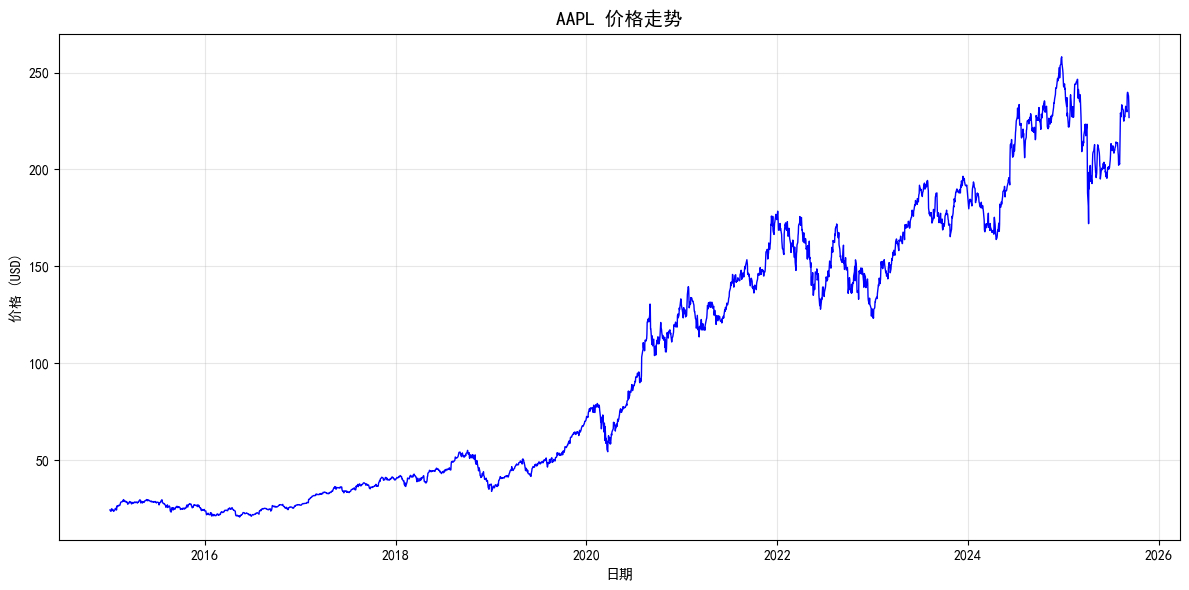

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(px.index, px.values, linewidth=1, color='blue')
plt.title(f'{TICKER} 价格走势', fontsize=14, fontweight='bold')
plt.xlabel('日期')
plt.ylabel('价格 (USD)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 策略一：SMA 交叉策略

**目的**：实现简单移动平均线交叉策略，快线上穿慢线时买入，下穿时卖出。

**金融含义**：SMA 交叉是最经典的趋势跟踪方法。快慢均线的交叉信号可以捕捉中期趋势的转换，但存在滞后性且在震荡市中容易产生假信号。


In [36]:
# SMA 参数
sma_fast = 10
sma_slow = 50

# 计算移动平均线
ma_fast = px.rolling(sma_fast).mean()
ma_slow = px.rolling(sma_slow).mean()

# 生成交易信号：快线 > 慢线时做多
signal_sma = (ma_fast > ma_slow).astype(int)

# t+1 执行，避免前视偏差
pos_sma = shift_exec(signal_sma)

# 计算换手率和交易成本
turnover_sma = turnover(pos_sma)
cost_sma = apply_cost(turnover_sma, commission_bps, slippage_bps, half_spread_bps)

# 含成本的策略收益
ret_sma = pos_sma * ret - cost_sma
equity_sma = equity(ret_sma)

print(f"SMA 策略参数: 快线 {sma_fast} 日, 慢线 {sma_slow} 日")
print(f"信号有效期: {signal_sma.dropna().index[0].strftime('%Y-%m-%d')} 开始")
print(f"总换手次数: {turnover_sma['AAPL'].sum():.1f}")


SMA 策略参数: 快线 10 日, 慢线 50 日
信号有效期: 2015-01-02 开始
总换手次数: 69.0


## 策略二：EMA 交叉策略

**目的**：实现指数移动平均线交叉策略，相比 SMA 对近期价格变化更敏感。

**金融含义**：EMA 给予近期价格更高权重，能更快响应价格变化，但也可能产生更多噪声信号。在趋势明确时优于 SMA，在震荡市中可能劣于 SMA。


In [37]:
# EMA 参数
ema_fast = 12
ema_slow = 26

# 计算指数移动平均线
ema_fast_line = px.ewm(span=ema_fast, adjust=False).mean()
ema_slow_line = px.ewm(span=ema_slow, adjust=False).mean()

# 生成交易信号
signal_ema = (ema_fast_line > ema_slow_line).astype(int)

# t+1 执行
pos_ema = shift_exec(signal_ema)

# 计算换手率和交易成本
turnover_ema = turnover(pos_ema)
cost_ema = apply_cost(turnover_ema, commission_bps, slippage_bps, half_spread_bps)

# 含成本的策略收益
ret_ema = pos_ema * ret - cost_ema
equity_ema = equity(ret_ema)

print(f"EMA 策略参数: 快线 {ema_fast} 日, 慢线 {ema_slow} 日")
print(f"信号有效期: {signal_ema.dropna().index[0].strftime('%Y-%m-%d')} 开始")
print(f"总换手次数: {turnover_ema.values.sum():.1f}")


EMA 策略参数: 快线 12 日, 慢线 26 日
信号有效期: 2015-01-02 开始
总换手次数: 85.0


## 策略三：MACD 策略

**目的**：实现 MACD（12,26,9）策略，利用 MACD 线与信号线的交叉产生交易信号。

**金融含义**：MACD 通过双重平滑减少噪声，能更好地识别趋势动量的变化。当 MACD 线上穿信号线时，表明短期动量转强，适合买入；反之则卖出。


In [38]:
# MACD 参数 (12,26,9)
macd_fast = 12
macd_slow = 26
macd_signal_period = 9

# 计算 MACD 指标
ema_12 = px.ewm(span=macd_fast, adjust=False).mean()
ema_26 = px.ewm(span=macd_slow, adjust=False).mean()
macd_line = ema_12 - ema_26
macd_signal = macd_line.ewm(span=macd_signal_period, adjust=False).mean()

# 生成交易信号：MACD 线 > 信号线时做多
signal_macd = (macd_line > macd_signal).astype(int)

# t+1 执行
pos_macd = shift_exec(signal_macd)

# 计算换手率和交易成本
turnover_macd = turnover(pos_macd)
cost_macd = apply_cost(turnover_macd, commission_bps, slippage_bps, half_spread_bps)

# 含成本的策略收益
ret_macd = pos_macd * ret - cost_macd
equity_macd = equity(ret_macd)

print(f"MACD 策略参数: ({macd_fast},{macd_slow},{macd_signal_period})")
print(f"信号有效期: {signal_macd.dropna().index[0].strftime('%Y-%m-%d')} 开始")
print(f"总换手次数: {turnover_macd.values.sum():.1f}")


MACD 策略参数: (12,26,9)
信号有效期: 2015-01-02 开始
总换手次数: 191.0


## 绩效指标对比表

**目的**：计算并对比各策略的关键绩效指标，包括年化收益、波动率、夏普比率、最大回撤和年化换手率。

**金融含义**：通过标准化指标比较策略优劣。夏普比率衡量风险调整后收益，最大回撤反映策略的风险控制能力，换手率直接影响交易成本。


In [39]:
ret

Ticker,AAPL
Date,
2015-01-02,0.000000
2015-01-05,-0.028172
2015-01-06,0.000094
2015-01-07,0.014022
2015-01-08,0.038422
...,...
2025-09-04,0.005493
2025-09-05,-0.000375
2025-09-08,-0.007551


In [53]:
# 计算各策略绩效
strategies = {
    'Buy&Hold': ret,
    'SMA': ret_sma,
    'EMA': ret_ema,
    'MACD': ret_macd
}

turnovers = {
    'Buy&Hold': pd.Series(0, index=ret.index),
    'SMA': turnover_sma['AAPL'],
    'EMA': turnover_ema['AAPL'],
    'MACD': turnover_macd['AAPL']
}

# 计算绩效指标
results = []
years = len(ret) / 252

print(turnover_ema['AAPL'].sum())

for name, ret_series in strategies.items():

    perf_metrics = perf(ret_series['AAPL'])
    annual_turnover = turnovers[name].sum() / years
    
    results.append({
        'Strategy': name,
        'CAGR': perf_metrics['CAGR'],
        'Vol': perf_metrics['Vol'],
        'Sharpe': perf_metrics['Sharpe'],
        'MaxDD': perf_metrics['MaxDD'],
        'Turnover/yr': annual_turnover
    })

# 生成对比表
perf_df = pd.DataFrame(results).set_index('Strategy')
perf_df = perf_df.round(4)

print("策略绩效对比表 (含交易成本 & t+1 执行)")
print("=" * 60)
print(perf_df)


85.0
策略绩效对比表 (含交易成本 & t+1 执行)
            CAGR     Vol  Sharpe   MaxDD  Turnover/yr
Strategy                                             
Buy&Hold  0.2331  0.2907  0.8664 -0.3852       0.0000
SMA       0.1369  0.1889  0.7739 -0.2619       6.4688
EMA       0.1367  0.1923  0.7625 -0.2856       7.9688
MACD      0.1785  0.1816  0.9958 -0.2744      17.9062


## 净值曲线对比

**目的**：可视化各策略的净值走势，直观比较策略表现和波动特征。

**金融含义**：净值曲线能清晰展示策略的历史表现、回撤期间和回撤幅度。趋势策略在趋势明确时表现优异，但在震荡期可能跑输买入持有。


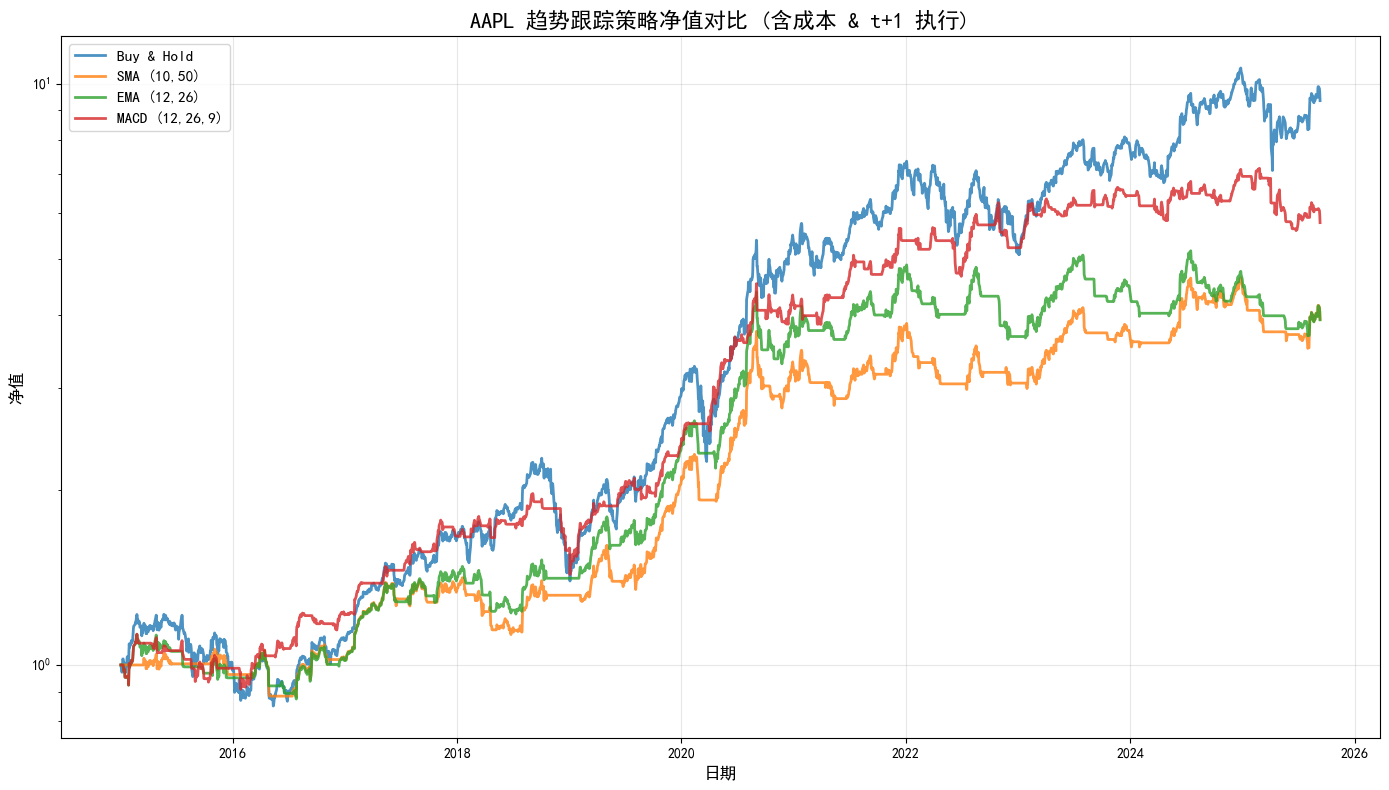

In [54]:
plt.figure(figsize=(14, 8))

plt.plot(equity_bh.index, equity_bh.values, label='Buy & Hold', linewidth=2, alpha=0.8)
plt.plot(equity_sma.index, equity_sma.values, label=f'SMA ({sma_fast},{sma_slow})', linewidth=2, alpha=0.8)
plt.plot(equity_ema.index, equity_ema.values, label=f'EMA ({ema_fast},{ema_slow})', linewidth=2, alpha=0.8)
plt.plot(equity_macd.index, equity_macd.values, label=f'MACD ({macd_fast},{macd_slow},{macd_signal_period})', linewidth=2, alpha=0.8)

plt.title(f'{TICKER} 趋势跟踪策略净值对比 (含成本 & t+1 执行)', fontsize=16, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 对数坐标更好地展示长期表现
plt.tight_layout()
plt.show()


## 回撤分析

**目的**：分析 SMA 策略的回撤特征，了解策略的风险暴露期间。

**金融含义**：回撤曲线显示策略从前期高点的损失幅度。深度回撤期往往对应策略失效或市场环境不利的时期，有助于理解策略的适用边界。


In [58]:
drawdown_sma['AAPL']

Date
2015-01-02    0.000000
2015-01-05    0.000000
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08    0.000000
                ...   
2025-09-04   -0.102140
2025-09-05   -0.102477
2025-09-08   -0.109254
2025-09-09   -0.122472
2025-09-10   -0.150781
Name: AAPL, Length: 2688, dtype: float64

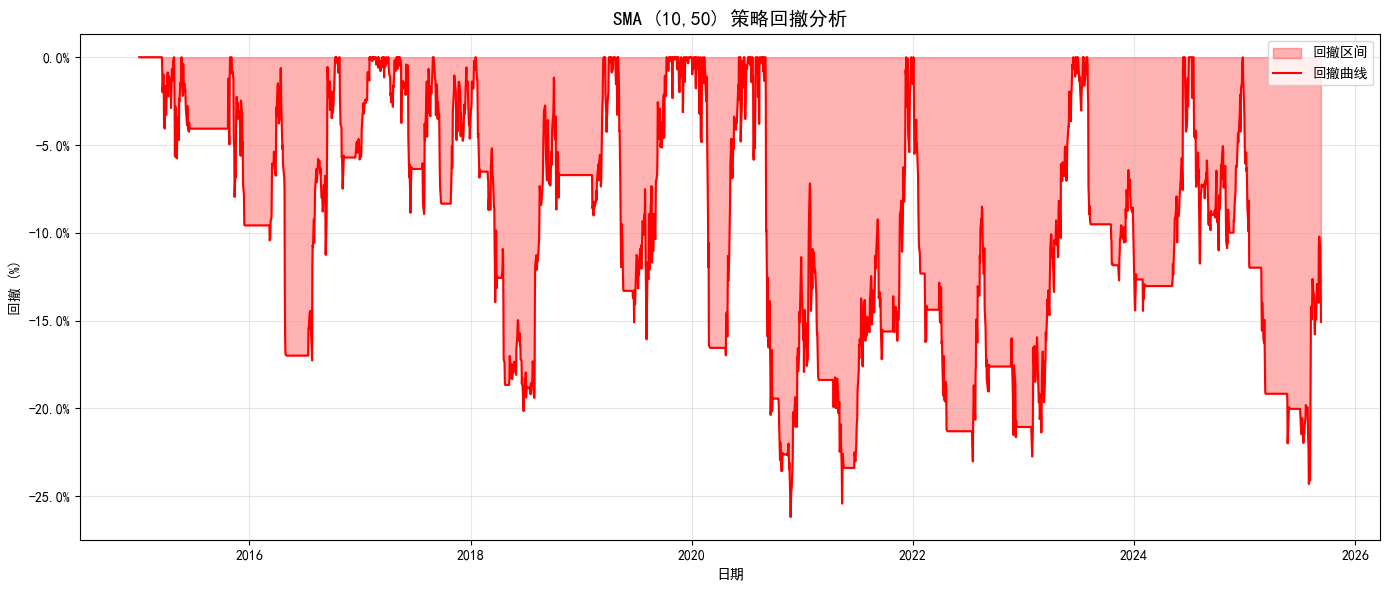

SMA 策略最大回撤: -26.19%
回撤超过 -10% 的天数: Ticker
AAPL    1190
dtype: int64 天


In [61]:
# 计算 SMA 策略的回撤序列
drawdown_sma = equity_sma / equity_sma.cummax() - 1

plt.figure(figsize=(14, 6))
plt.fill_between(drawdown_sma.index, drawdown_sma['AAPL'], 0, 
                 alpha=0.3, color='red', label='回撤区间')
plt.plot(drawdown_sma.index, drawdown_sma['AAPL'], 
         color='red', linewidth=1.5, label='回撤曲线')

plt.title(f'SMA ({sma_fast},{sma_slow}) 策略回撤分析', fontsize=14, fontweight='bold')
plt.xlabel('日期')
plt.ylabel('回撤 (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"SMA 策略最大回撤: {drawdown_sma.values.min():.2%}")
print(f"回撤超过 -10% 的天数: {(drawdown_sma < -0.1).sum()} 天")


## SMA 参数敏感性分析

**目的**：测试不同快慢均线组合的表现，寻找最优参数并评估参数稳定性。

**金融含义**：参数敏感性反映策略的鲁棒性。过度拟合的策略在参数微调时表现急剧变化，而稳健的策略应在合理参数范围内保持相对稳定的表现。


In [ ]:
# 参数网格
fast_values = [5, 10, 20]
slow_values = [30, 50, 100]

# 存储结果
sharpe_grid = pd.DataFrame(index=fast_values, columns=slow_values, dtype=float)
turnover_grid = pd.DataFrame(index=fast_values, columns=slow_values, dtype=float)

best_sharpe = -999
best_params = None
best_turnover = None

print("SMA 参数网格搜索 (含成本)...")

for fast in fast_values:
    for slow in slow_values:
        if fast >= slow:
            continue
            
        # 计算策略表现
        ma_f = px.rolling(fast).mean()
        ma_s = px.rolling(slow).mean()
        sig = (ma_f > ma_s).astype(int)
        pos = shift_exec(sig)
        turn = turnover(pos)
        cost = apply_cost(turn, commission_bps, slippage_bps, half_spread_bps)
        ret_strat = pos * ret - cost
        # 计算指标
        metrics = perf(ret_strat['AAPL'])
        annual_turn = turn.sum() / years
        
        sharpe_grid.loc[fast, slow] = metrics['Sharpe']
        turnover_grid.loc[fast, slow] = annual_turn.values
        
        # 记录最优参数
        if metrics['Sharpe'] > best_sharpe:
            best_sharpe = metrics['Sharpe']
            best_params = (fast, slow)
            best_turnover = annual_turn

print("\nSMA 参数 Sharpe 比率矩阵:")
print(sharpe_grid.round(3))

print(f"\n最优参数: 快线 {best_params[0]} 日, 慢线 {best_params[1]} 日")
print(f"最优 Sharpe: {best_sharpe:.3f}")
print(f"对应年化换手: {best_turnover['AAPL']:.1f} 次")


SMA 参数网格搜索 (含成本)...

SMA 参数 Sharpe 比率矩阵:
      30     50     100
5   0.873  0.856  0.659
10  0.747  0.774  0.486
20  0.724  0.623  0.570

最优参数: 快线 5 日, 慢线 30 日
最优 Sharpe: 0.873
Ticker
AAPL    10.96875
dtype: float64
对应年化换手: 11.0 次


## EMA 参数对比

**目的**：测试不同 EMA 参数组合，与 SMA 结果对比。

**金融含义**：EMA 参数敏感性通常高于 SMA，因为其对近期价格变化更敏感。在选择参数时需要平衡信号及时性与稳定性。


In [74]:
# EMA 参数测试
ema_params = [(10, 30), (12, 26), (15, 40)]
ema_results = []

for fast, slow in ema_params:
    ema_f = px.ewm(span=fast, adjust=False).mean()
    ema_s = px.ewm(span=slow, adjust=False).mean()
    sig = (ema_f > ema_s).astype(int)
    pos = shift_exec(sig)
    turn = turnover(pos)
    cost = apply_cost(turn, commission_bps, slippage_bps, half_spread_bps)
    ret_strat = pos * ret - cost
    
    metrics = perf(ret_strat['AAPL'])
    annual_turn = turn.sum() / years
    
    ema_results.append({
        'Params': f'({fast},{slow})',
        'Sharpe': metrics['Sharpe'],
        'Turnover/yr': annual_turn
    })

ema_df = pd.DataFrame(ema_results)
print("EMA 参数对比:")
print(ema_df.round(3))

best_ema = ema_df.loc[ema_df['Sharpe'].idxmax()]
print(f"\n最优 EMA 参数: {best_ema['Params']}")
print(f"最优 Sharpe: {best_ema['Sharpe']:.3f}")
print(f"对应年化换手: {best_ema['Turnover/yr']['AAPL']:.1f} 次")


EMA 参数对比:
    Params  Sharpe                            Turnover/yr
0  (10,30)   0.727  Ticker
AAPL    8.15625
dtype: float64
1  (12,26)   0.763  Ticker
AAPL    7.96875
dtype: float64
2  (15,40)   0.742  Ticker
AAPL    6.28125
dtype: float64

最优 EMA 参数: (12,26)
最优 Sharpe: 0.763
对应年化换手: 8.0 次


## 数据导出

**目的**：保存策略信号、仓位、收益和净值数据，供后续分析使用。

**金融含义**：将回测结果结构化存储，便于后续的组合构建、风险分析或策略改进。数据的可复现性是量化研究的基础要求。


In [77]:
px

Ticker,AAPL
Date,
2015-01-02,24.261049
2015-01-05,23.577576
2015-01-06,23.579794
2015-01-07,23.910433
2015-01-08,24.829123
...,...
2025-09-04,239.779999
2025-09-05,239.690002
2025-09-08,237.880005


In [78]:
# 准备导出数据
export_data = pd.DataFrame({
    'px': px['AAPL'],
    'ret': ret['AAPL'],
    'signal_sma': signal_sma['AAPL'],
    'pos_sma': pos_sma['AAPL'],
    'ret_sma': ret_sma['AAPL'],
    'equity_sma': equity_sma['AAPL'],
    'signal_ema': signal_ema['AAPL'],
    'pos_ema': pos_ema,
    'ret_ema': ret_ema,
    'equity_ema': equity_ema,
    'signal_macd': signal_macd,
    'pos_macd': pos_macd,
    'ret_macd': ret_macd,
    'equity_macd': equity_macd,
    'equity_bh': equity_bh
})

# 创建目录并保存
ensure_dir('data')
export_path = 'data/day2_trend.parquet'
export_data.to_parquet(export_path)

print(f"数据已保存至: {export_path}")
print(f"列名: {list(export_data.columns)}")
print(f"数据行数: {len(export_data)}")

# 保存参数信息
params_info = {
    'ticker': TICKER,
    'start_date': START,
    'cost_bps': cost_bps,
    'sma_params': (sma_fast, sma_slow),
    'ema_params': (ema_fast, ema_slow),
    'macd_params': (macd_fast, macd_slow, macd_signal_period)
}

print(f"\n策略参数: {params_info}")


ValueError: Data must be 1-dimensional, got ndarray of shape (2688, 1) instead

## 要点小结

通过本节学习，我们掌握了以下关键概念：

1. **趋势跟踪的滞后性与成本权衡**：趋势策略本质上是跟随性的，存在天然滞后。更敏感的参数能更快捕捉趋势，但也会增加换手率和交易成本。

2. **t+1 执行的重要性**：使用 `shift(1)` 确保信号在下一期执行，避免前视偏差。这是回测与实盘一致性的关键保证。

3. **不同移动平均的特性差异**：
   - SMA：平滑但滞后，适合稳定趋势
   - EMA：敏感但噪声多，适合快速变化市场
   - MACD：双重平滑，平衡了敏感性与稳定性

4. **参数稳定性优于最优性**：在参数选择时，"平坦高原"优于"尖峰最优"。稳健的策略在参数微调时表现相对稳定。

5. **交易成本的现实影响**：即使是几个基点的成本，在高频换手的策略中也会显著侵蚀收益。成本建模是策略实用性评估的必要环节。

6. **风险管理的重要性**：最大回撤和回撤持续期是衡量策略可接受性的重要指标，直接影响投资者的心理承受能力。
